# Support Vector Machine Models

**Support vector machines (SVMs)** are a widely used and powerful category of machine learning algorithms. There are many variations on the basic idea of an SVM. An SVM attempts to **maximally seperate** classes by finding the **suport vector** with the lowest error rate or maximum separation. SVMs can use many types of **kernel functions**. The most common kernel functions are **linear** and the **radial basis function** or **RBF**. The linear basis function attempts to separate classes by finding hyperplanes in the feature space that maximally separate classes. The RBF uses set of local Gaussian shaped basis kernels to find a nonlinear separation of the classes. 

## Example: Iris dataset

As a first example you will use SVMs to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [2]:
## Import packages
library(ggplot2)
library(gridExtra)
library(repr)
library(dplyr)
library(caret)
library(e1071)
library(ROCR)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions


Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



To get a feel for these data, you will now load and plot them. Execute this code and examine the results. 

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


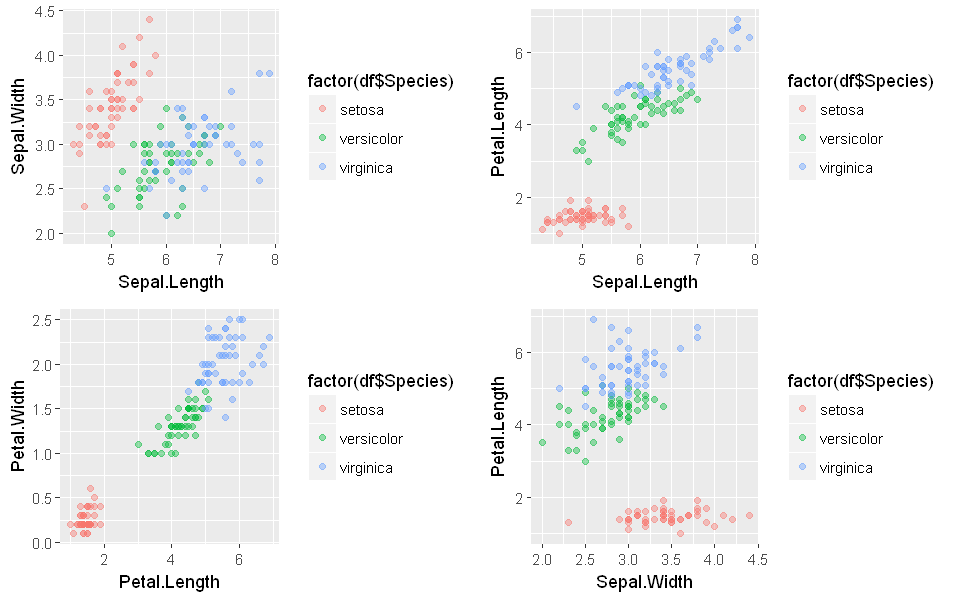

In [3]:
single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species)), alpha = 0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

head(iris, 10)   
plot_iris(iris) 

You can see that Setosa (in red) is well separated from the other two categories. The Versicolor (in green) and the Virginica (in blue) show considerable overlap. The question is how well our classifier will separate these categories. 

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 67% of the cases are being used as the test dataset. 

In [4]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times = 1, p = 0.33, list = FALSE)
training = iris[partition,] # Create the training sample
dim(training)
test = iris[-partition,] # Create the test sample
dim(test)

[1] 51  5

[1] 99  5

As is always the case with machine learning, numeric features  must be scaled. Execute the code in the cell below to scale the training and test datasets:

In [22]:
num_cols = c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.2646501,0.4563512,-1.348274,-1.287390
5,-0.9016267,1.4161001,-1.293220,-1.287390
6,-0.4175955,2.1359118,-1.128059,-1.027876
9,-1.6276734,-0.2634605,-1.293220,-1.287390
10,-1.0226345,0.2164140,-1.238167,-1.417146
11,-0.4175955,1.6560373,-1.238167,-1.287390


Now you will define and fit an SVM model. The code in the cell uses the `svm` function from the e1071 package. The model formula is specified along with the data, the requirement not to scale and the `type` of model required. Execute this code.

In [6]:
svm_mod = svm(factor(Species) ~ ., data = training, scale = FALSE, type = 'C-classification')

Next, the code in the cell below uses the `predict` method is used to compute the multinomial class probabilities from the scaled features. Execute this code. 

In [7]:
test[,'scores'] = predict(svm_mod, newdata = test)
test[1:10,]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,scores
1,-0.78061890,1.17616289,-1.293220,-1.287390,setosa,setosa
2,-1.02263448,-0.02352326,-1.293220,-1.287390,setosa,setosa
4,-1.38565786,0.21641397,-1.238167,-1.287390,setosa,setosa
7,-1.38565786,0.93622566,-1.293220,-1.157633,setosa,setosa
8,-0.90162669,0.93622566,-1.238167,-1.287390,setosa,setosa
12,-1.14364227,0.93622566,-1.183113,-1.287390,setosa,setosa
14,-1.74868124,-0.02352326,-1.458381,-1.417146,setosa,setosa
15,0.06643565,2.37584904,-1.403328,-1.287390,setosa,setosa
16,-0.05457214,3.33559795,-1.238167,-1.027876,setosa,setosa
19,-0.05457214,1.89597458,-1.128059,-1.157633,setosa,setosa


You can see actual species and predicted species. 

It is time to evaluate the model results. Keep in mind that the problem has been made deliberately difficult, by having more test cases than training cases. The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from previous labs to deal with a three category problem. Execute this code and examine the results.

In [8]:
print_metrics = function(df, label){
    ## Compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)

    ## Compute and print accuracy 
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm), 3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)), '\n \n')                           

    ## Compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))    
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))    
    metrics = sapply(c(precision, recall, F1), round, 3)        
    metrics = t(matrix(metrics, nrow = nrow(cm), ncol = ncol(cm)))       
    dimnames(metrics) = list(c('Precision', 'Recall', 'F1'), unique(test$Species))      
    print(metrics)
}  
print_metrics(test, 'Species')      

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         29         4
  virginica       0          2        31

Accuracy =  0.939 
 
          setosa versicolor virginica
Precision      1      0.879     0.939
Recall         1      0.935     0.886
F1             1      0.906     0.912


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified. 
2. The overll accuracy is 0.94. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 51 cases. 
3. The precision, recall and  F1 for each of the classes is relatively good. Versicolor has the worst metrics since it has the largest number of misclassified cases. 

How important are each of the features for this model? The R Caret package provides the capability to find out. As a first step, `gbm` models must be trained using the the Caret `train` function. The code in the cell below does this, using the default model arguments. The default arguments for the model are specified with the `tuneGrid` argument of `train`. Execute the code.

In [23]:
trControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)

svm_mod_train = train(factor(Species) ~ ., 
                      data = training, 
                      method = "svmLinear", 
                      verbose = FALSE,
                      trControl = trControl,
                      scale = FALSE, 
                      type = 'C-svc')
svm_mod_train

Support Vector Machines with Linear Kernel 

51 samples
 4 predictor
 3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 47, 45, 46, 48, 46, 46, ... 
Resampling results:

  Accuracy   Kappa    
  0.9538889  0.9282516

Tuning parameter 'C' was held constant at a value of 1

With the Caret model object trained, the feature importance can be computed and displayed. Execute this code and examine the results. 

In [10]:
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(svm_mod_train, scale = FALSE)$importance
imp

,setosa,versicolor,virginica
Sepal.Length,1.0000000,0.9446367,1.0000000
Sepal.Width,0.8961938,0.8961938,0.7283737
Petal.Length,1.0000000,1.0000000,1.0000000
Petal.Width,1.0000000,1.0000000,1.0000000


Examine the table above. Notice that `Sepal.Width` has the least importance for classifying each of the species. 

Execute this code, and answer **Question 1** on the course page.

Next, you will train and evaluate a model using the three most important features by executing the code in the cell below:

In [11]:
svm_mod_3 = svm(factor(Species) ~ Sepal.Length + Petal.Length + Petal.Width, data = training, 
                 scale = FALSE, type = 'C-classification')
test[,'scores'] = predict(svm_mod, newdata = test)
print_metrics(test, 'Species')  

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         29         4
  virginica       0          2        31

Accuracy =  0.939 
 
          setosa versicolor virginica
Precision      1      0.879     0.939
Recall         1      0.935     0.886
F1             1      0.906     0.912


These results are identical to those obtained with the model with all features. The simpler model is preferred since it is likely to generalize better. 

The code in the cell below plots the classes of the iris flower along with the classification errors shown by shape. Execute this code and examine the results.  

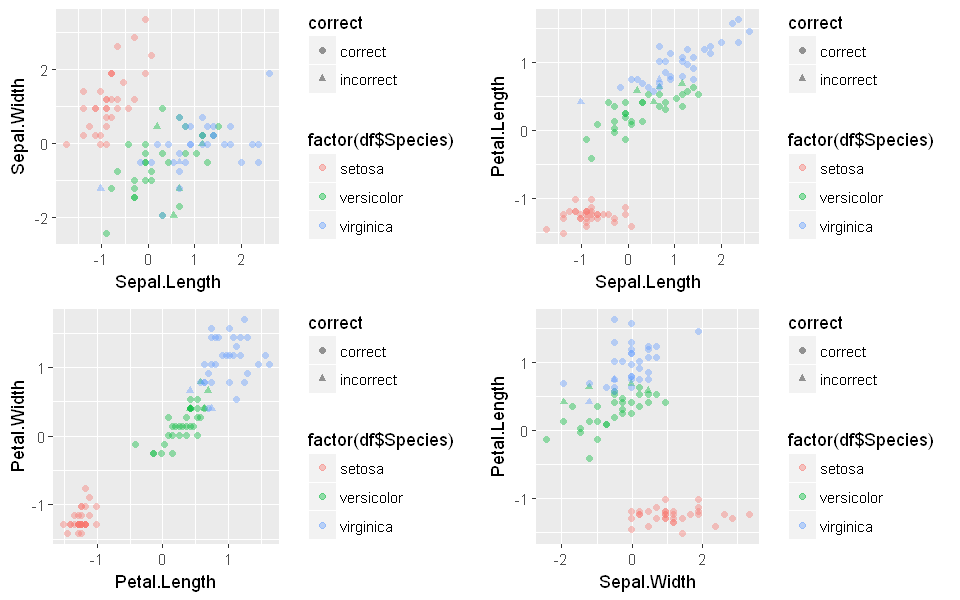

In [12]:
## Create column of correct-incorrect classification
test$correct = ifelse(test$Species == test$scores, 'correct', 'incorrect')

single_plot_classes = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species), shape = correct), alpha = 0.4)
}

plot_iris_classes = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot_classes(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot_classes(df, 'Sepal.Length', 'Petal.Length'),
        single_plot_classes(df, 'Petal.Length', 'Petal.Width'),
        single_plot_classes(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

plot_iris_classes(test)

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

## Another example

Now, you will try a more complex example using the credit scoring data. You will use the prepared data which has been prepared by removing duplicate cases. Some columns which are know not to be predictive are removed. Execute the code in the cell below to load the dataset for the example. 

In [13]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
## Subset the data frame
credit = credit[,c('checking_account_status', 'loan_duration_mo', 'credit_history', 'loan_amount', 'savings_account_balance',
                   'time_employed_yrs', 'payment_pcnt_income', 'time_in_residence', 'property', 'age_yrs',
                   'other_credit_outstanding', 'number_loans', 'job_category', 'dependents', 'telephone', 'bad_credit' )]
print(dim(credit))
names(credit)

[1] 999  16


[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "loan_amount"             
 [5] "savings_account_balance"  "time_employed_yrs"       
 [7] "payment_pcnt_income"      "time_in_residence"       
 [9] "property"                 "age_yrs"                 
[11] "other_credit_outstanding" "number_loans"            
[13] "job_category"             "dependents"              
[15] "telephone"                "bad_credit"

Cross validation will be used to train the model. Since folds will be selected from the entire dataset the numeric features are scaled in batch. Execute the code in the cell below to accomplish this: 

In [14]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
2.2464282,0.9483849,-0.86876113,-0.7645835,-1.19202026,-0.7035652,-0.4283287
-0.7397312,-0.4170067,-0.86876113,0.1414888,1.18945982,-0.7035652,2.3323187
1.7487350,1.6323204,-0.86876113,1.0475610,0.83664795,-0.7035652,2.3323187
0.2556552,0.5655086,0.02505181,1.0475610,1.54227168,1.0276211,2.3323187
1.2510417,2.0477820,-0.86876113,1.0475610,-0.04538171,-0.7035652,2.3323187
0.2556552,-0.1552623,0.02505181,1.0475610,1.54227168,-0.7035652,-0.4283287


The code in the cell below uses the capability of the R Caret package to estimate the best hyperparameters using 10 fold cross validation with 5 repeats. There are a few points to note here:
1. Since there is significant class imbalance, recall is used as the metric to optimize. A function, `recallSummary` is used to define this metric. This function is specified in the `trainControl` object.
2. The model is trained using all features as can be seen from the model formula in the Caret `train` function. 
3. The recall metric is specified as a `metric` in the call to `train`. 
4. The `train` function automatically generates and searches a hyperparameter grid and prints the metrics. 

Execute this code, examine the result, and answer **Question 3** on the course page.

In [15]:
recallSummary = function (data, lev = NULL, model = NULL) {
                    out = recall(data$obs, data$pred)  
                    names(out) <- "recall"
                    out
}

fitControl = trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 5,
                           summaryFunction = recallSummary)

set.seed(3344)
svm_fit <- train(factor(bad_credit) ~ .,  # make label a factor since classification model
                 data = credit, 
                 metric = "recall", 
                 method = "svmRadial", # Radial basis SVM
                 trControl = fitControl,
                 class.weights =c(0.34,0.66),
                 verbose = FALSE)
svm_fit

Support Vector Machines with Radial Basis Function Kernel 

999 samples
 15 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 899, 899, 899, 899, 899, 899, ... 
Resampling results across tuning parameters:

  C     recall   
  0.25  0.7749243
  0.50  0.7749243
  1.00  0.7749243

Tuning parameter 'sigma' was held constant at a value of 0.02020209
recall was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.02020209 and C = 0.25.

The grid of hyperpameters searched by the Caret package is limited to just `C`. The grid along with the recall metric is shown in the printed table. 

Given the optimal hyperparameter, which features are the most important? The code in the cell below computes and displays feature importance using the Caret `varImp` function. Execute this code and examine the results. 

loess r-squared variable importance

                           Overall
checking_account_status  1.000e+02
loan_duration_mo         4.817e+01
loan_amount              3.285e+01
savings_account_balance  2.648e+01
age_yrs                  8.423e+00
payment_pcnt_income      5.586e+00
credit_history           4.356e+00
time_employed_yrs        3.406e+00
other_credit_outstanding 3.017e+00
number_loans             2.121e+00
telephone                1.326e+00
property                 1.233e+00
job_category             1.128e+00
time_in_residence        2.622e-03
dependents               0.000e+00


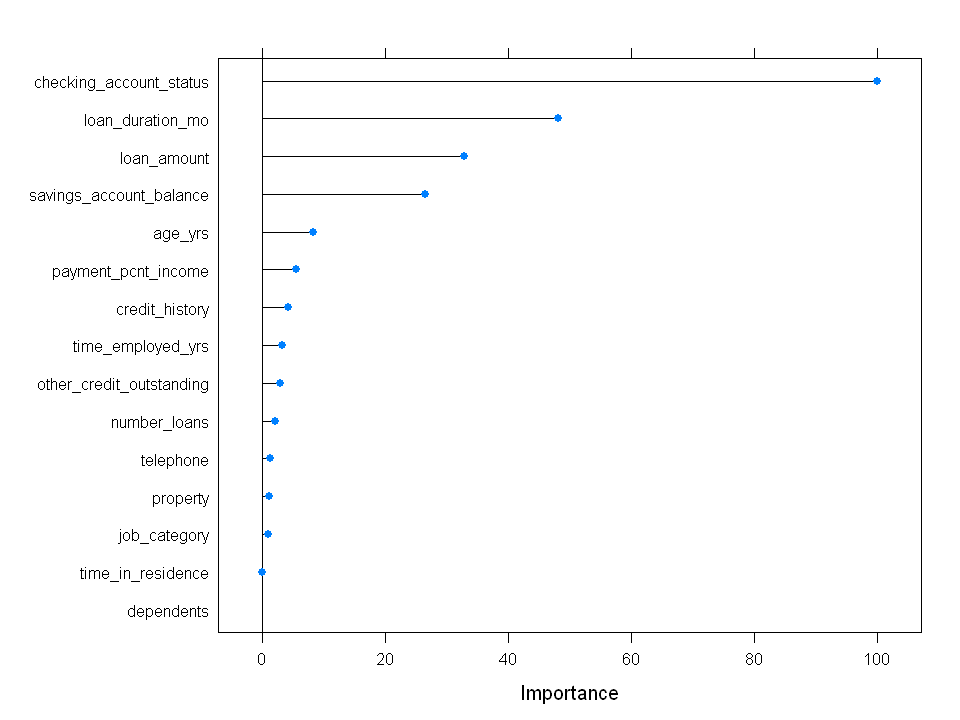

In [16]:
options(repr.plot.width=8, repr.plot.height=6)
var_imp = varImp(svm_fit)
print(var_imp)
plot(var_imp)

Examine these results. Notice that the standard deviation of the mean of the AUC is more than an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

Now, you will build and test a model using the estimated optimal hyperparameters. As a first step, execute the code in the cell below to create training and testing dataset.

In [20]:
set.seed(3344)
credit_sub = select(credit, checking_account_status, loan_duration_mo, loan_amount,
                 savings_account_balance, age_yrs, payment_pcnt_income, credit_history,
                 time_employed_yrs, other_credit_outstanding, number_loans, bad_credit)

## Reduce number of folds to speed up execution
fitControl = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 4,
                           summaryFunction = recallSummary)

svm_fit <- train(factor(bad_credit) ~ .,
                 data = credit_sub, 
                 metric = "recall", 
                 method = "svmRadial", # Gradient boosted tree model
                 trControl = fitControl,
                 class.weights = c(0.34,0.66),
                 verbose = FALSE)
svm_fit

Support Vector Machines with Radial Basis Function Kernel 

999 samples
 10 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 4 times) 
Summary of sample sizes: 799, 800, 799, 799, 799, 799, ... 
Resampling results across tuning parameters:

  C     recall   
  0.25  0.7712336
  0.50  0.7712336
  1.00  0.7712336

Tuning parameter 'sigma' was held constant at a value of 0.03110092
recall was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.03110092 and C = 0.25.

The code in the cell below defines a nonlinear SVM model object using the estimated optimal model hyperparameters and then fits the model to the training data. Execute this code.

In [21]:
binary.eval <- function(df, fold){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 1 & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 0 & df$score == 1, 'FP',
                           ifelse(df$bad_credit == 0 & df$score == 0, 'TN', 'FN')))
  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
    
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('TrueNeg', 'TruePos')
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R) 
  data.frame = data.frame(fold = as.character(fold),
                          accuracy = (TP + TN)/(TP + TN + FP + FN),
                          precision = P,
                          recall = R,
                          F1 = F1)
 }


Create_Folds = function(df, folds){
    ## Create a vector of the fold assignments
    nrows = nrow(df)
    ncount = nrows/folds
    ## Concatenate vectors of fold number
    fold = rep(1, ncount)
    for(i in seq(2, folds, by = 1)){
        fold = c(fold, rep(i, ncount))
    }
    fold
}


Cross_Validate_Mod = function(df, svm_mod, folds){
    ## Create a vector of the fold assignments
    fold = Create_Folds(df, folds)
    
    ## Randomly shuffle the rows of the data frame
    shuffle = sample(seq(1, nrow(df), by = 1))
    df = df[shuffle,]
    
    ## Loop over number of folds to fit and evaluate the model
    training = df[fold != 1,]
    test = df[fold == 1, ]
    test[,'scores'] = predict(svm_mod, test)
    evals = binary.eval(test, 1)
    for(i in seq(2, folds, by = 1)){
        training = df[fold != i,]
        test = df[fold == i, ]
        test[,'scores'] = predict(svm_mod, test)
        evals = rbind(evals, binary.eval(test, i))
    }
    
    ## Compute some summary statistics and append to the data rame
    evals = rbind(evals, data.frame(fold = 'Mean',
                          accuracy = mean(evals[,2]),
                          precision = mean(evals[,3]),
                          recall = mean(evals[,4]),
                          F1 = mean(evals[,5])))
    
    evals = rbind(evals, data.frame(fold = 'std',
                          accuracy = sd(evals[,2]),
                          precision = sd(evals[,3]),
                          recall = sd(evals[,4]),
                          F1 = sd(evals[,5])))
    evals
}

Cross_Validate_Mod(credit, svm_fit, 10)

fold,accuracy,precision,recall,F1
1,0.9814815,0.96969697,0.96969697,0.96969697
2,1.0000000,1.00000000,1.00000000,1.00000000
3,0.9696970,0.93333333,0.96551724,0.94915254
4,0.9797980,0.96875000,0.96875000,0.96875000
5,1.0000000,1.00000000,1.00000000,1.00000000
6,1.0000000,1.00000000,1.00000000,1.00000000
7,1.0000000,1.00000000,1.00000000,1.00000000
8,0.9797980,1.00000000,0.92307692,0.96000000
9,0.9898990,0.97435897,1.00000000,0.98701299
10,0.9797980,0.97222222,0.97222222,0.97222222


As expected, the hyperparameters of the SVM model object reflect those specified. 

The code in the cell below scores and prints evaluation metrics for the model, using the test data subset. 

Execute this code, examine the results, and answer **Question 3** on the course page.

## Summary

In this lab you have accomplished the following:
1. Used a linear and nonlinear SVM model to classify the cases of the iris data. For this particular problem there  was no difference between the linear and nonlinear models. 
2. Used 5 fold to find estimated optimal hyperparameters for a nonlinear SVM model to classify credit risk cases. The model appears to generalize well.  